<a href="https://colab.research.google.com/github/anisha99999/DNNs/blob/master/Session3_dnn_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [0]:
transform = transforms.Compose ([transforms.ToTensor()])

trainset = MNIST (root = '/content/data/', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader (trainset, batch_size = 64, shuffle = True, num_workers = 2)

testset = MNIST (root = '/content/data/', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader (testset, batch_size = 64, shuffle = False, num_workers = 2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [75]:
dataiter = iter (trainloader)
images, labels = dataiter.next ()
print (type (images))
print (images.shape)
print (labels.shape)
print (labels)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([5, 7, 2, 9, 4, 9, 1, 6, 9, 7, 5, 1, 8, 7, 3, 1, 8, 1, 5, 9, 4, 0, 8, 5,
        8, 9, 9, 9, 1, 4, 1, 1, 8, 3, 8, 7, 1, 2, 0, 6, 9, 8, 9, 1, 6, 2, 4, 1,
        5, 7, 2, 9, 4, 5, 1, 0, 8, 4, 9, 3, 2, 8, 6, 3])


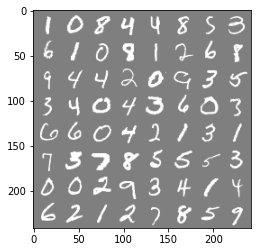

    1     0     8     4


In [76]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow (img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy ()
    plt.imshow (np.transpose (npimg, (1, 2, 0)))
    plt.show ()

# get some random training images
dataiter = iter (trainloader)
images, labels = dataiter.next ()

# show images
imshow (torchvision.utils.make_grid (images))
# print labels
print(' '.join ('%5s' % classes[labels[j]] for j in range (4)))

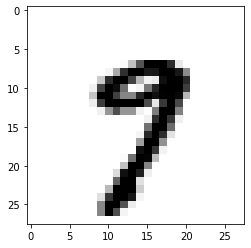

In [77]:
plt.imshow(images[63].numpy().squeeze(), cmap='gray_r');

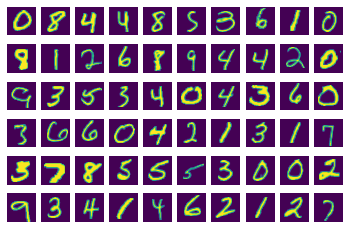

In [78]:
figure = plt.figure()
num_of_images = 60
for index in range (1, num_of_images + 1):
    plt.subplot (6, 10, index)
    plt.axis ('off')
    plt.imshow (images[index].numpy().squeeze())

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d (in_channels = 1, out_channels = 32, kernel_size = 11, stride = 1, padding = 0) #18x18x32
        self.pool1 = nn.MaxPool2d (2, 2) # max pool 9x9x32
        self.conv2 = nn.Conv2d (in_channels = 32, out_channels = 10, kernel_size = 7, stride = 1, padding = 0) #3x3x10
        #self.conv3 = nn.Conv2d (in_channels = 10, out_channels = 10, kernel_size = 5, stride = 1, padding = 0) 
        self.pool2 = nn.MaxPool2d (2, 2) # max pool 1x1x10
        self.linear = nn.Linear (in_features = 10, out_features = 10) #array of 10 variables 

    def forward (self, x):
        x = F.relu (self.conv1 (x))
        x = self.pool1(x)
        x = self.conv2 (x)
        x = self.pool2 (x)

        x = x.reshape (-1, 10 * 1 * 1)
        x = self.linear (x)
        #x = F.softmax (x, dim = 0)
        return x

net = Net()

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
net.to (device)

cuda


Net(
  (conv1): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 10, kernel_size=(7, 7), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=10, out_features=10, bias=True)
)

In [81]:
pytorch_total_params = sum(p.numel() for p in net.parameters())
print (pytorch_total_params)
print(list(p.numel() for p in net.parameters()))

19704
[3872, 32, 15680, 10, 100, 10]


In [82]:
import time
import torch.optim as optim
from tqdm import notebook

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
epochs = 10

tqdm_e = notebook.tqdm ([i + 1 for i in range (epochs)], total = epochs)
for i, e in enumerate (tqdm_e):
    time0 = time.time ()

    running_loss = 0
    print ('Training for Epoch ' + str (e) + '...')
    tqdm_tl = notebook.tqdm (trainloader, total = int (len (trainloader)))
    for images, labels in (tqdm_tl):
    #for images, labels in trainloader:
        # Training pass
        optimizer.zero_grad()
        
        output = net (images.cuda())
        loss = criterion (output, labels.cuda())
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()

    correct_count, all_count = 0, 0
    print ('Computing Accuracy on Training set...')
    tqdm_vl = notebook.tqdm (trainloader, total = int (len (trainloader)))
    for images, labels in tqdm_vl:
      true_label = labels.numpy()
      with torch.no_grad():
          logps = net (images.cuda())

      # Output of the network are log-probabilities, need to take exponential for probabilities
      ps = torch.exp(logps)
      for j in range (ps.shape[0]):
        probab = list (ps.cpu().numpy()[j])
        pred_label = probab.index(max(probab))
        if (true_label[j] == pred_label):
          correct_count += 1
        all_count += 1
    train_acc = correct_count / all_count

    print ('Computing Accuracy on Test set...')
    correct_count, all_count = 0, 0
    tqdm_vl = notebook.tqdm (testloader, total = int (len (testloader)))
    for images, labels in tqdm_vl:
      true_label = labels.numpy()
      with torch.no_grad():
          logps = net (images.cuda())

      # Output of the network are log-probabilities, need to take exponential for probabilities
      ps = torch.exp(logps)
      for j in range (ps.shape[0]):
        probab = list (ps.cpu().numpy()[j])
        pred_label = probab.index(max(probab))
        if (true_label[j] == pred_label):
          correct_count += 1
        all_count += 1
    test_acc = correct_count / all_count

    print("Epoch {} - Time Taken: {}, Training loss: {} - Train Accuracy: {} Test Accuracy: {}".format(e, (time.time ()-time0)/60, running_loss/len(trainloader), train_acc, test_acc))
    if correct_count / all_count > 0.98:
      optimizer = optim.Adam(net.parameters(), lr = 0.0001)

Training for Epoch 1...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 1 - Time Taken: 0.36907123724619545, Training loss: 0.29808383928274296 - Train Accuracy: 0.96755 Test Accuracy: 0.971
Training for Epoch 2...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 2 - Time Taken: 0.3573052406311035, Training loss: 0.09006908372330513 - Train Accuracy: 0.9811166666666666 Test Accuracy: 0.9823
Training for Epoch 3...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 3 - Time Taken: 0.356607719262441, Training loss: 0.05638507649358084 - Train Accuracy: 0.98475 Test Accuracy: 0.9848
Training for Epoch 4...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 4 - Time Taken: 0.35196901162465416, Training loss: 0.05206247675083657 - Train Accuracy: 0.9858166666666667 Test Accuracy: 0.9846
Training for Epoch 5...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 5 - Time Taken: 0.3613615353902181, Training loss: 0.049161361431135045 - Train Accuracy: 0.9871666666666666 Test Accuracy: 0.9859
Training for Epoch 6...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 6 - Time Taken: 0.3644398212432861, Training loss: 0.04660934333338031 - Train Accuracy: 0.9877 Test Accuracy: 0.9864
Training for Epoch 7...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 7 - Time Taken: 0.356212862332662, Training loss: 0.04442366674097616 - Train Accuracy: 0.9886 Test Accuracy: 0.987
Training for Epoch 8...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 8 - Time Taken: 0.3523536086082458, Training loss: 0.04259164607140428 - Train Accuracy: 0.9889166666666667 Test Accuracy: 0.9867
Training for Epoch 9...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 9 - Time Taken: 0.35953035751978557, Training loss: 0.04063056507455642 - Train Accuracy: 0.9888333333333333 Test Accuracy: 0.9865
Training for Epoch 10...



Computing Accuracy on Training set...



Computing Accuracy on Test set...



Epoch 10 - Time Taken: 0.36509031454722085, Training loss: 0.03905299841078805 - Train Accuracy: 0.98945 Test Accuracy: 0.9876



In [0]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()
    print (ps / 100000)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,12), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')

    ax2.barh(np.arange(10), ps / 100000)
    ax2.set_aspect(1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 10)
    plt.tight_layout()

Predicted Digit = 4
[2.74671782e-07 2.49935317e-05 1.80892088e-07 2.36585606e-07
 1.34436338e+01 8.60661920e-08 1.13906249e-06 3.47253609e-05
 1.04370415e-06 3.39670410e-02]
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


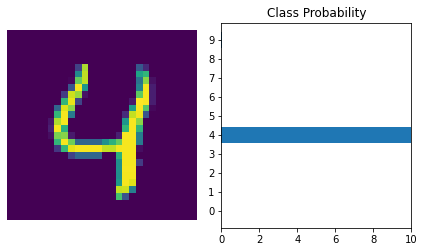

In [99]:
images, labels = next (iter (testloader))

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = net (images.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp (logps)
probab = list (ps.cpu().numpy()[4])
print ("Predicted Digit =", probab.index (max (probab)))
view_classify (images[4], ps[4])
print(labels)

In [0]:
layer_dict = net.state_dict ()

In [107]:
visualisation = {}

def hook_fn(m, i, o):
  visualisation[m] = o 

def get_all_layers(net):
  for name, layer in net._modules.items():
    #If it is a sequential, don't register a hook on it
    # but recursively register hook on all it's module children
    if isinstance(layer, nn.Sequential):
      get_all_layers(layer)
    else:
      # it's a non sequential. Register a hook
      layer.register_forward_hook(hook_fn)

get_all_layers(net)

  
out = net (images[4:5].cuda ())

# Just to check whether we got all layers
visualisation.keys()  
#print(visualisation.items ())
print(out)


tensor([[-3.5948,  0.9160, -4.0124, -3.7440, 14.1114, -4.7552, -2.1724,  1.2449,
         -2.2598,  8.1306]], device='cuda:0', grad_fn=<AddmmBackward>)


4 8
4 8
2 5
2 5
1 1


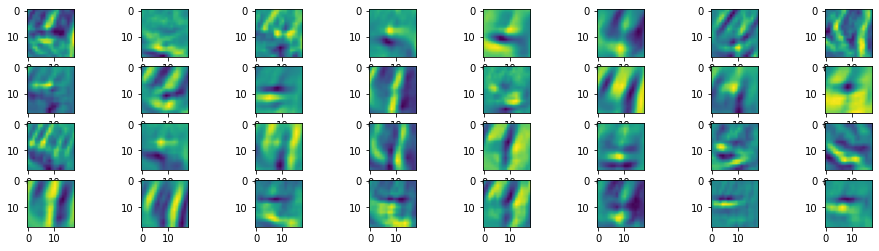

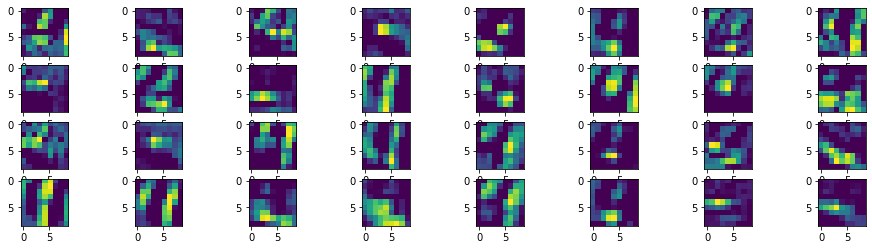

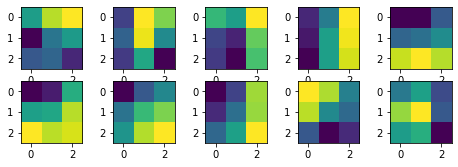

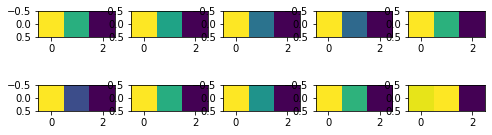

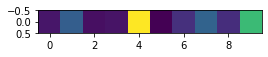

In [108]:
for key, value in visualisation.items ():
  #print (visualisation.items ())
  #print(value.cpu ().detach (). numpy ()[0][1])
  if len (value.shape) == 4:
    if value.shape[1] >= 32:
      plot_x, plot_y = 4, 8
    elif value.shape[1] >= 10 and value.shape[2] == 1:
      plot_x, plot_y = 2, 5
    elif value.shape[1] >= 10:
      plot_x, plot_y = 2, 5
  else:
    plot_x, plot_y = 1, 1
  print (plot_x, plot_y)

  fig, ax = plt.subplots(plot_x, plot_y, figsize = (plot_x * 4, plot_y / 2))
  for i in range (value.shape[1]):
    x = int (i / plot_y)
    y = i % plot_y
    
    try:
      if value.shape[1] == 10 and value.shape[2] == 1:
        a = value.cpu ().detach ().numpy ()[0][i]
        #print(a)
        b = [[3]]
        c = [[32]]
        b = [np.append (c, np.append (a + 20, b))]
        ax[x, y].imshow (b)
      else:
        #print(i)
        ax[x, y].imshow (value.cpu ().detach ().numpy ()[0][i])
    except:
      plt.imshow (value.cpu ().detach ().numpy ())
      #print(value.cpu ().detach ().numpy ()[0][i])
      #print(value.shape[2])
      #print('nnn')